# Юнит 4. Финальный проект. Банковский скоринг.

### Импортируем библиотеки

In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import accuracy_score

import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import warnings
warnings.filterwarnings("ignore")  # Убирает некритические сообщения

Позаботимся о воспроизводимости результатов

In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

### Загрузка и изучение датасета

In [3]:
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [5]:
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [6]:
sample_submission.head()

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [7]:
train.shape

(73799, 19)

In [8]:
test.shape

(36349, 18)

In [9]:
sample_submission.shape

(24354, 2)

In [10]:
train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

### Проверим данные на пропуски

In [11]:
train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [12]:
test.isna().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

Пропуски есть только в признаке education. Посмотрим на содержание признака и распределение содержащихся в нем значений. 

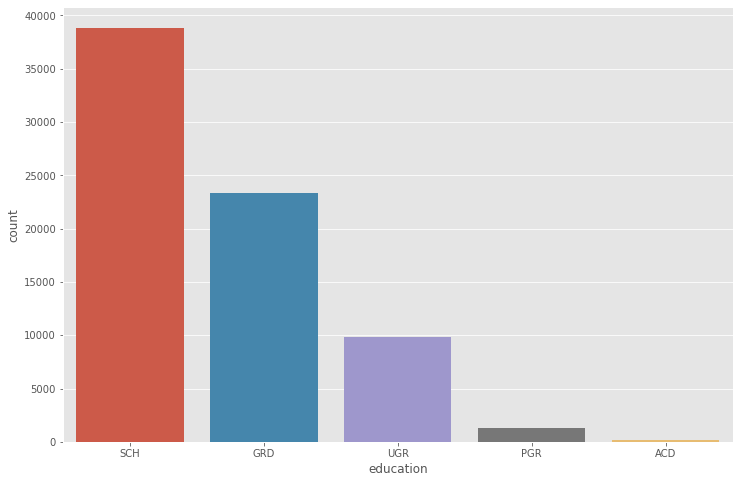

In [13]:
sns.countplot(train['education'])

Максимальное количество клиентов заявили о наличии школьного образования SCH. Так как наличие школьного образования в нашей стране обязательно (а дата-сет "наш"), то можем смело заполнить пропуски в признаке этим значением (оно и логично и оно же - мода)

In [14]:
train.education.fillna('SCH', inplace = True)

теперь в test проведем аналогичное исследование и заполнение пропусков

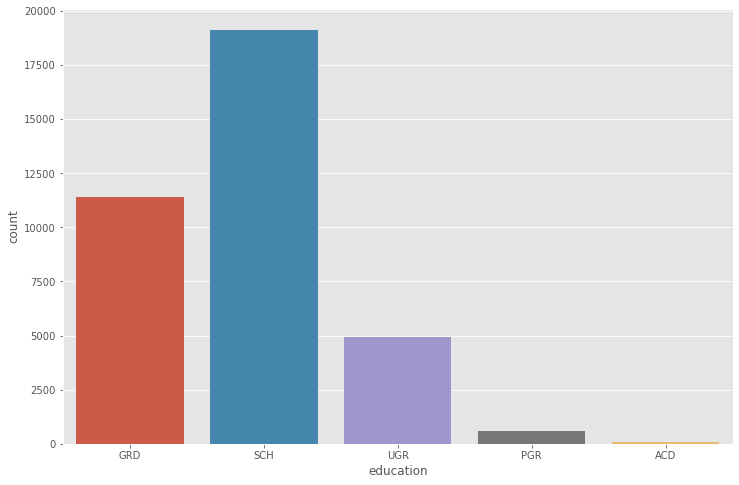

In [15]:
sns.countplot(test['education'])

In [16]:
test.education.fillna('SCH', inplace = True)

контрольная проверка на пропуски

In [17]:
train.isna().sum(), test.isna().sum()

(client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 default             0
 dtype: int64,
 client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 dtype: int64)

## Поработаем с признаками

### Даты

Для начала приведем признак app_date к виду, с которым удобно будет работать (то есть в формат datetime)

In [18]:
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)

Сделаем признак - количество дней от даты заявки до сегодняшнего (10 февраля 2021 года) числа. Думаю, что с этим признаком модели можно будет справиться легче, чем с собственно датой (которую пришлось бы переводить в более понятный модели числовой формат)

In [19]:
# На основе признака app_date делаем новый признак
current_date = pd.to_datetime('10FEB2021')
# Количество дней, прошедших со дня подачи заявки
train['days'] = (current_date - train.app_date).dt.days
test['days'] = (current_date - test.app_date).dt.days

## Разделим колонки по типам данным для большего удобства работы и изучения

In [39]:
bin_cols = ['sex', 'car', 'car_type', 'good_work',
            'foreign_passport']  # бинарные признаки
cat_cols = [
    'education', 'home_address', 'work_address', 'sna', 'first_time',
    'region_rating'
]  # категориальные признаки
num_cols = [
    'days', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']  # численные признаки

## Численные признаки

В первую очередь проверим численные признаки на наличие выбросов

#### Признак age

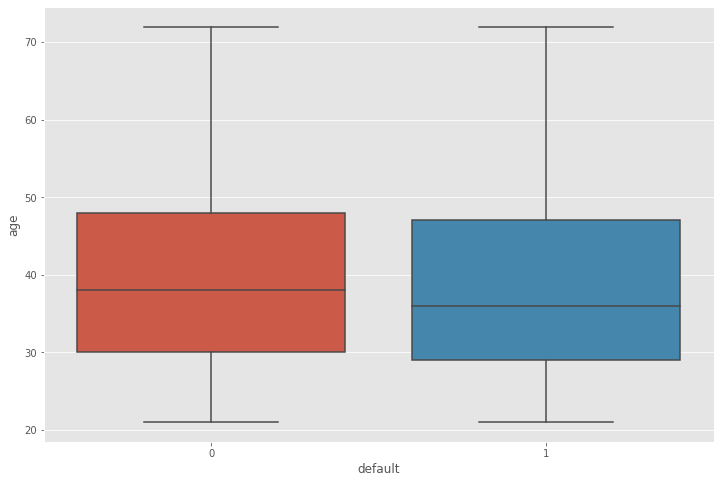

In [21]:
sns.boxplot(x=train.default, y=train.age)
# выбросов нет

Данные чистые - выбросов нет. Кроме того, мы видим, что невозврат кредита немного более характерен для более молодых людей.

#### Признак days

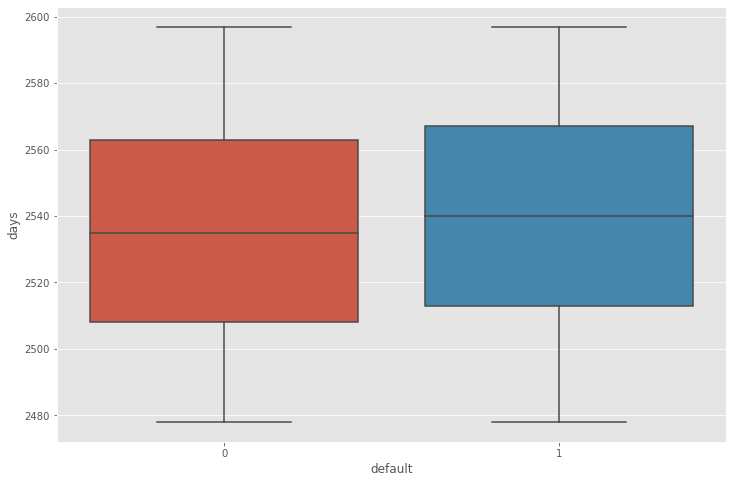

In [22]:
sns.boxplot(x=train.default, y=train.days)

Видим, что выбросов нет. Кроме того, понятно, что в "последнее время" у банка улучшилась ситуация с возвратом кредитов (то есть среди тех, кто кредит вернул, больше количество людей, подававших заявки в недавнее время)

#### Признак decline_app_cnt

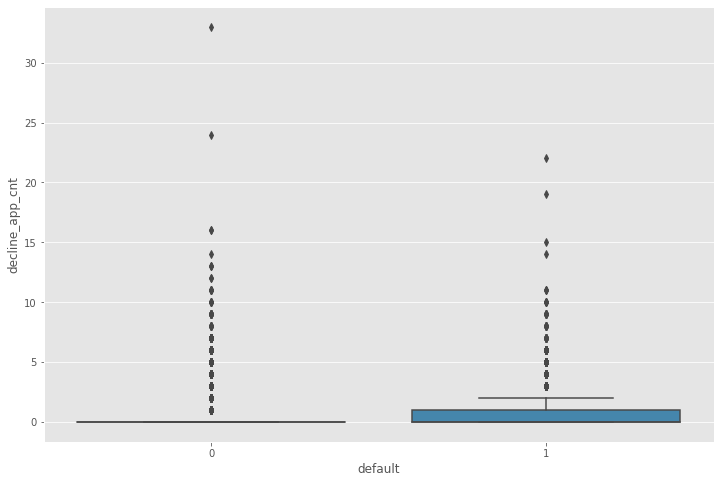

In [23]:
sns.boxplot(x=train.default, y=train.decline_app_cnt)

Количество отклоненных заявок у тех, кто не вернул кредит, существенно больше, чем у тех, кто кредит вернул. В данных есть выбросы, но "уничтожать" их не имеет смысла, так как медиана близка к нулю и мы можем потерять много важной информации... 

#### Признак score_bki

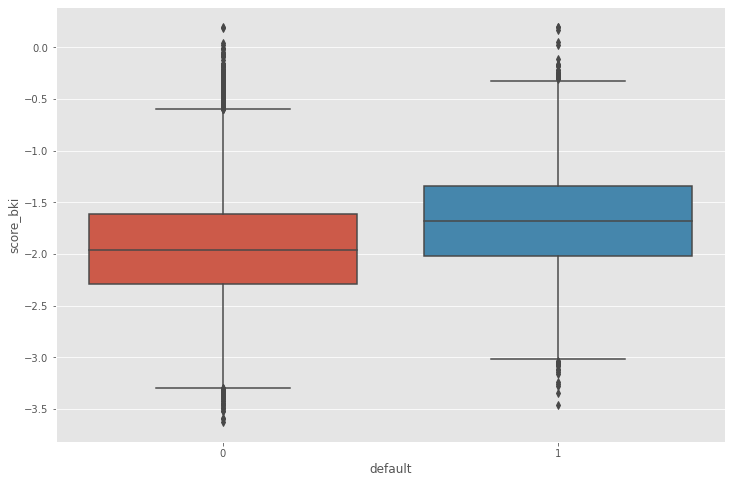

In [24]:
sns.boxplot(x=train.default, y=train.score_bki)

Средний скоринговый балл у тех, кто не вернул кредит, выше, чем у тех, кто вернул. Видимо, скорринговый бал обратно зависим от надежности клиента. Видим наличие выбросов, которые нужно будет удалить.

#### Признак bki_request_cnt

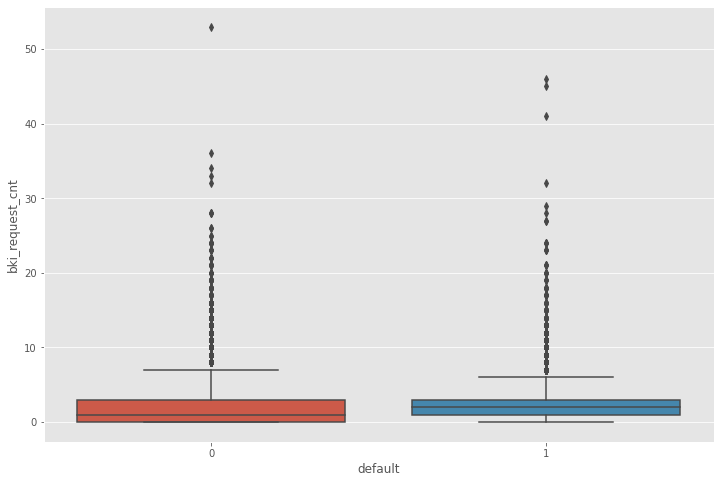

In [25]:
sns.boxplot(x=train.default, y=train.bki_request_cnt)

Средний показатель числа запросов в БКИ у тех, кто не вернул кредит, выше. Выбросы присутствуют. 

#### Признак income

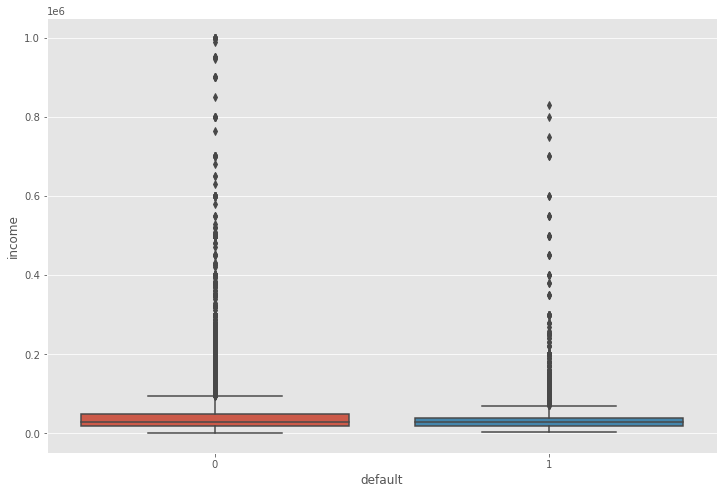

In [26]:
sns.boxplot(x=train.default, y=train.income)

График подтверждает то, что чем выше доход, тем чаще дают кредит :) Есть выбросы, но я бы не трогал их, так как мы можем потерять важную информацию... 

Предварительно проведенная работа показала, что удаление выбросов из численных признаков существенно ухудшает работу модели, так что выбросы удалять не будем (но механизм удаления оставлю в этом ноутбуке).

In [27]:
# def outliers_iqr(ys):
#     quartile_1, quartile_3 = np.percentile(ys, [25, 75])
#     iqr = quartile_3 - quartile_1
#     lower_bound = quartile_1 - (iqr * 1.5)
#     upper_bound = quartile_3 + (iqr * 1.5)
#     return lower_bound, upper_bound

Убираем выбросы

In [28]:
# num_cols_out = ['bki_request_cnt', 'score_bki']
# for colname in num_cols_out:
#     d = outliers_iqr(train[colname])
#     train_out = train.loc[train[colname].between(d[0], d[1])]

После того как мы почистили данные от выбросов и прежде чем переходить к причесыванию данных, посмотрим на целевую переменную... 

Теперь займемся бинарными признаками.

### Бинарные признаки

Переведем флаги бинарных признаков в 0 и 1

In [29]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])

Проверим результат наших действий

In [30]:
train[bin_cols].sample(5), test[bin_cols].sample(5)

(       sex  car  car_type  good_work  foreign_passport
 68476    0    1         1          0                 0
 41914    1    1         0          1                 0
 45339    1    1         0          0                 0
 63321    1    0         0          0                 0
 68625    0    0         0          0                 0,
        sex  car  car_type  good_work  foreign_passport
 16160    0    1         1          1                 0
 743      1    0         0          0                 1
 25814    0    0         0          0                 0
 19963    0    0         0          0                 1
 26584    1    0         0          0                 0)

### Категориальные признаки

Переведем в dummies признак education. Остальные признаки на самом деле относятся к тому типу, когда между катеориями есть разница в ранге.

In [31]:
train = pd.get_dummies(train, columns=['education'])
test = pd.get_dummies(test, columns=['education'])

In [32]:
train.head(5)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
0,25905,2014-02-01,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0,2566,0,0,0,1,0
1,63161,2014-03-12,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0,2527,0,0,0,1,0
2,25887,2014-02-01,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0,2566,0,0,0,1,0
3,16222,2014-01-23,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0,2575,0,0,0,1,0
4,101655,2014-04-18,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0,2490,0,1,0,0,0


### Добавим несколько численных признаков.

#### Доход в зависимости от рейтинга региона.

Добавим признак, который покажет насколько доход клиента отличается от среднего дохода по его региону. Будем считать, что резницы между регионом с одинаковым рейтингом нет. 

In [33]:
# # словарик со средним уровнем дохода для каждого региона (чтобы не пересчитывать каждый раз)
# income_dict = dict(train.groupby(['region_rating']).income.mean())

# # Теперь "зарезервируем" под новый признак колонку

# train['income_by_reg'] = 0
# test['income_by_reg'] = 0

# # Теперь заполним признак значениями

# for i in range(len(train['income'])):
#     t = income_dict[train.region_rating.loc[i]]
#     train['income_by_reg'].loc[i] = round(train.income.loc[i] - t)

# # Для заполнения признака в test я специально пользуюсь данными по среднему доходу региона из train. 
# # Там больше данных и средний доход будет "объективнее". 
# # Если бы мы знали название региона, то можно было бы посмотреть средний доход по этому региону из каких-то статистических данных...

# for i in range(len(test['income'])):
#     t = income_dict[test.region_rating.loc[i]]
#     test['income_by_reg'].loc[i] = round(test.income.loc[i] - t)

После анализа получившегося датасета стало понятно, что признак лишний. Он сильно скоррелирован с признаком income, но при этом его распределение существенно хуже. Кроме того, я добавлял еще признак не сделана ли заявка в какой-то предпраздничный период (или напротив - после праздника), но понимаю, что этого не нужно, так как эта информация в неявном виде подается в модель числом дней, прошедших с момента подачи заявки до сегодняшнего дня. 

Следующие два признака я подсмотрел у людей в Kaggle. Так как они никаким образом логически не объяснимы - просто решил их скопировать, так как они дают некоторый прирост значений метрик.

In [33]:
# Два этих признака повышают f1-score на 0,01, но только вместе.
train['new_one'] = (train['score_bki']/train['age'])**train['sna']
test['new_one'] = (test['score_bki']/test['age'])**test['sna']
num_cols.append('new_one')

train['new_one1'] = (train['score_bki']/train['age']
                     )**train['foreign_passport']
test['new_one1'] = (test['score_bki']/test['age'])**test['foreign_passport']
num_cols.append('new_one1')

### Целевая переменная

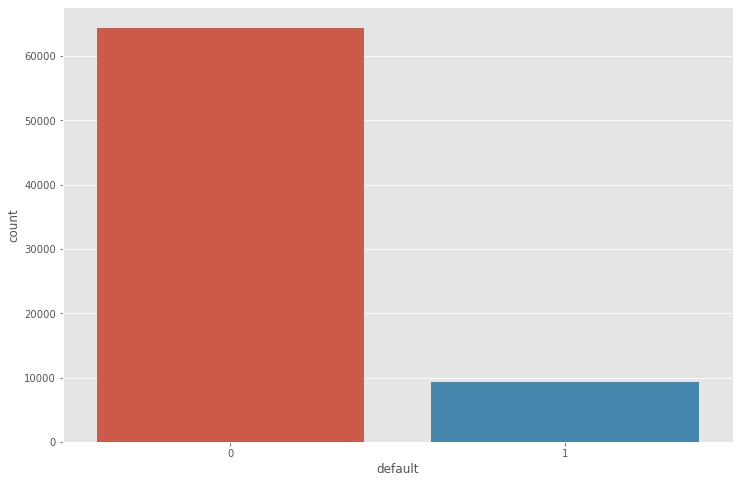

In [34]:
sns.countplot(train['default'])

Видим очень серьезный дисбаланс между значениями целевой переменной. По вполне понятным причинам клиентов, которые не вернули кредит, значительно меньше, чем "положительных" клиентов. Для устранения дисбаланса применим oversampling

In [35]:
train_0 = train.query('default == 0')
train_1 = train.query('default == 1')
koeff = int(len(train_0)/len(train_1))
for i in range(koeff):
    train = train.append(train_1).reset_index(drop=True)  # объединяем

Посмотрим на результат наших трудов

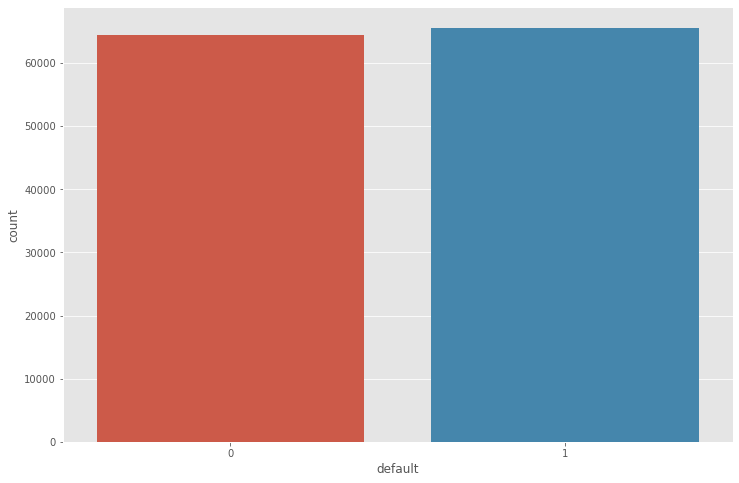

In [36]:
sns.countplot(train['default'])

Дисбаланс ликвидирован. 

### Распределение числовых признаков

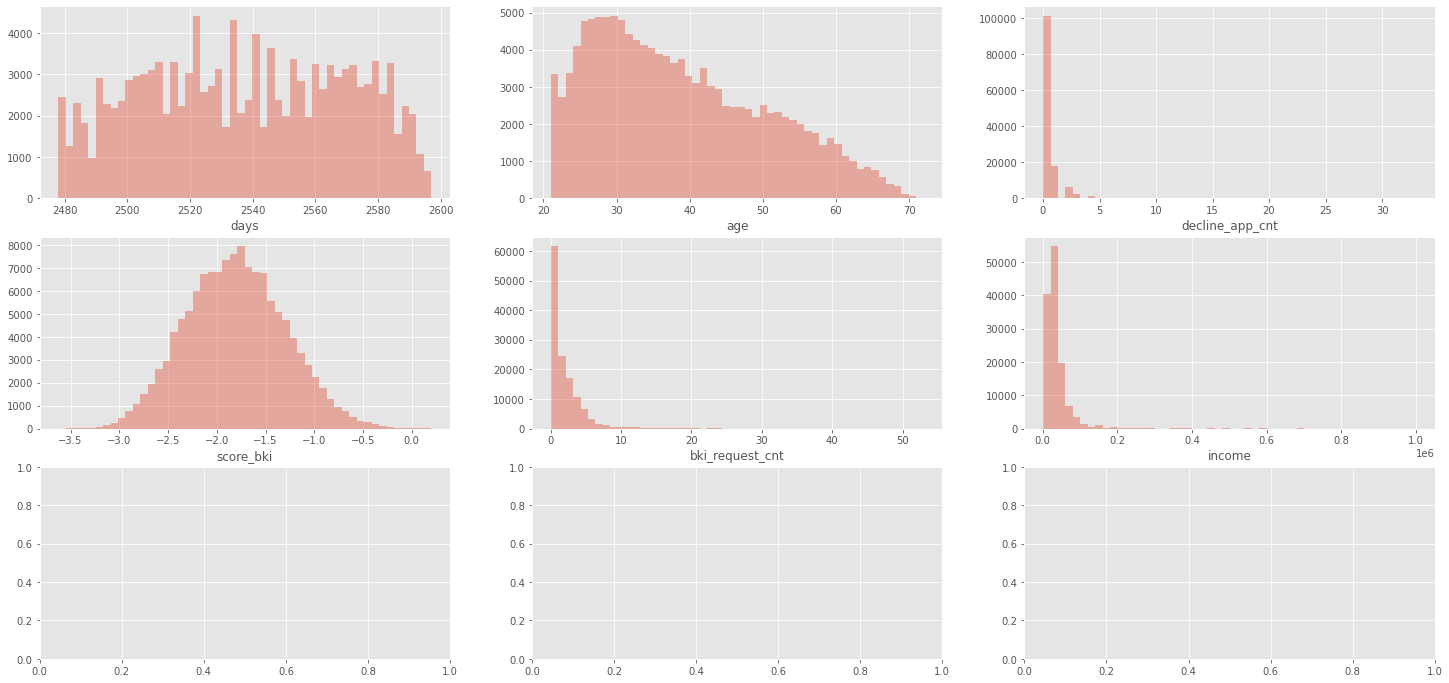

In [40]:
fig, axes = plt.subplots(3, 3, figsize=(25, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

Только у признака score_bki распределение практически нормальное. Распределение остальных признаков сильно смещено. Попробуем устранить это - как учили - логарифмированием. 

In [41]:
num_cols_log = ['days',
                'age',
                'decline_app_cnt',
                'bki_request_cnt',
                'income',
                'new_one',
                'new_one1']

for i in num_cols_log:
    train[i] = np.log(train[i] + 1)

Посмотрим на результат

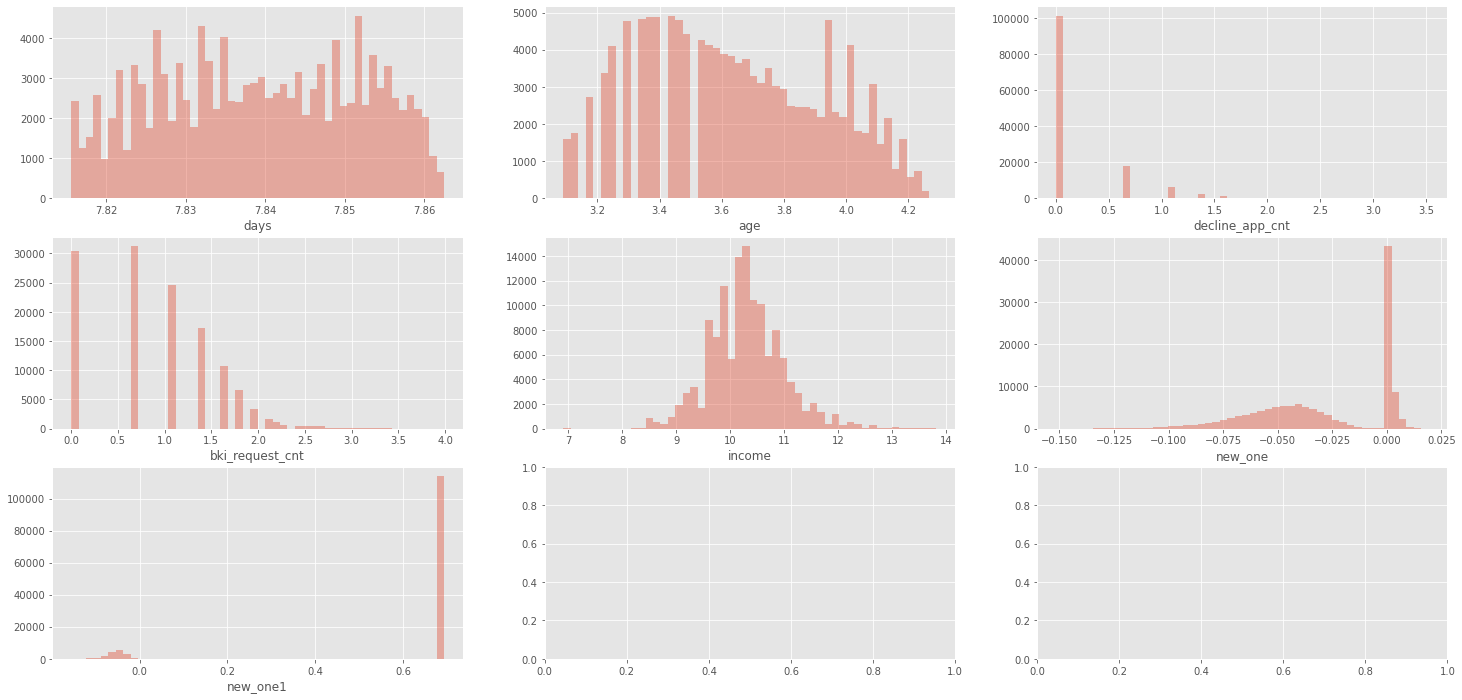

In [42]:
fig, axes = plt.subplots(3, 3, figsize=(25, 12))
for col, i in zip(num_cols_log, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

Распределение признаков выглядит "нормальнее" (только распределение days выглядит так же и распределение new_one стало странноватым)

Сделаем ту же обработку для датасета test

In [43]:
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)

Прежде чем преобразовать категориальные переменные в dummies, посмотрим на корреляцию признаков

In [49]:
corr = train[num_cols].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,days,age,decline_app_cnt,score_bki,bki_request_cnt,income,new_one,new_one1
days,1.000,-0.020,0.025,0.063,0.010,-0.006,0.023,-0.005
age,-0.020,1.000,-0.144,-0.096,0.059,-0.094,0.156,0.037
decline_app_cnt,0.025,-0.144,1.000,0.229,0.143,-0.014,0.087,0.040
score_bki,0.063,-0.096,0.229,1.000,0.152,-0.006,0.305,0.037
bki_request_cnt,0.010,0.059,0.143,0.152,1.000,0.096,0.066,-0.000
income,-0.006,-0.094,-0.014,-0.006,0.096,1.000,-0.104,-0.250
new_one,0.023,0.156,0.087,0.305,0.066,-0.104,1.000,0.158
new_one1,-0.005,0.037,0.040,0.037,-0.000,-0.250,0.158,1.000


In [48]:
num_cols = ['days', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'new_one', 'new_one1']

Признаки практически не скоррелированы, так что можно их смело все использовать.Сильная корреляция наблюдается только у признаков income и income_by_reg (понятно почему - второй - производное из первого). Какой из этих признаков удалить... решу чуть позже

### Значимость непрерывных переменных

Text(0.5, 0, 'F-value')

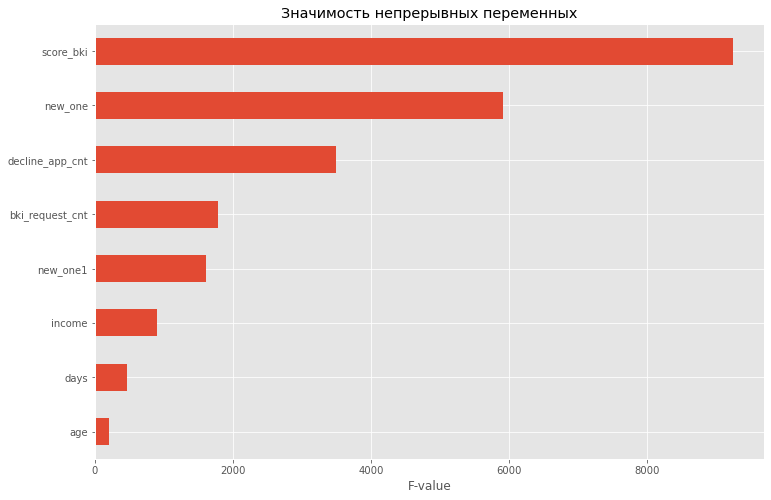

In [50]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость непрерывных переменных')
plt.xlabel('F-value')

### Значимость бинарных и категориальных переменных

Text(0.5, 1.0, 'Значимость бинарных переменных')

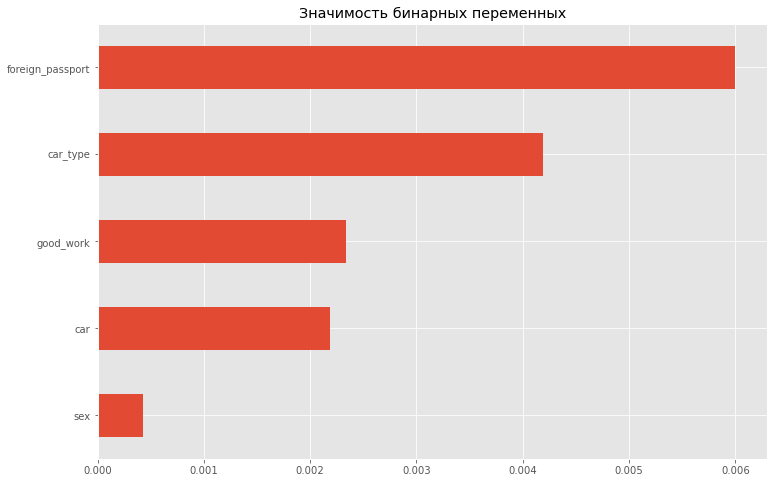

In [51]:
imp_bin = Series(mutual_info_classif(train[bin_cols],
                                     train['default'],
                                     discrete_features=True),
                 index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных переменных')

In [53]:
cat_cols_wide = ['education_ACD', 'education_GRD',
                 'education_PGR', 'education_SCH',
                 'education_UGR', 'home_address',
                 'work_address', 'sna', 'first_time', 'region_rating']

Text(0.5, 1.0, 'Категориальные переменные')

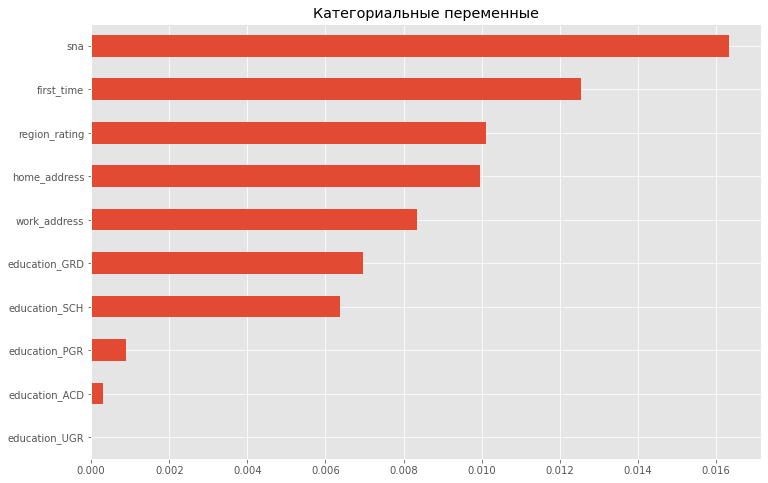

In [54]:
imp_cat = pd.Series(mutual_info_classif(train[cat_cols_wide],
                                        train['default'],
                                        discrete_features=True),
                    index=train[cat_cols_wide].columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Категориальные переменные')

#### Добавим полиномиальных признаков

In [55]:
poly = PolynomialFeatures(2)

x_p_train = poly.fit_transform(train[num_cols].values)
x_p_test = poly.fit_transform(test[num_cols].values)

### Подготовка данных к машинному обучению

#### Стандартизируем числовые признаки

In [59]:
# Сначала в базе train
X_num = StandardScaler().fit_transform(x_p_train)
X_num.shape

(130031, 45)

In [60]:
# Теперь в базе test
X_test_num = StandardScaler().fit_transform(x_p_test)
X_test_num.shape

(36349, 45)

#### Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [61]:
X = np.hstack([X_num, train[bin_cols].values, train[cat_cols_wide].values])
Y = train['default'].values

id_test = test['client_id']
test = np.hstack([X_test_num, test[bin_cols].values, test[cat_cols_wide].values])

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True)

### Подбор гиперпараметров (регуляризация)

In [63]:
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 166.81005372000593


### Обучение и метрики

In [64]:
# Обучим модель

model = LogisticRegression(penalty='l2', C=166.81005372000593, max_iter=800)
model.fit(X_train, y_train)

LogisticRegression(C=166.81005372000593, max_iter=800)

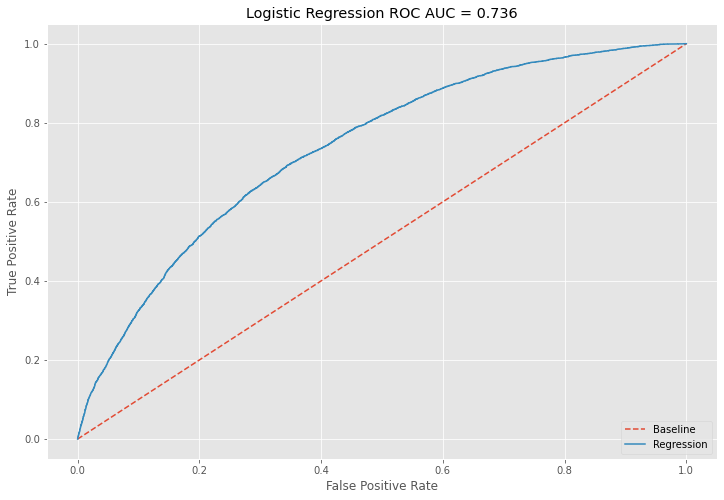

In [65]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

# Визуализация ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [72]:
roc_auc

0.7357495715168673

Посмотрим на остальные метрики

In [67]:
# Функция выводит метрики accuracy и f1-score
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [68]:
Y_predicted = model.predict(X_test)
print_logisitc_metrics(y_test, Y_predicted)

acc = 0.67 F1-score = 0.68


In [69]:
# confusion matrix
cm = confusion_matrix(y_test, Y_predicted)
cm

array([[8508, 4477],
       [4001, 9021]])

Теперь скормим модели тестовую базу и создадим файл для submission

In [70]:
model = LogisticRegression(penalty='l2', C=166.81005372000593, max_iter=800)
model.fit(X, Y)
probs = model.predict_proba(test)
probs = probs[:, 1]

In [71]:
my_submission = pd.DataFrame({'client_id': id_test,
                              'default': probs})
my_submission.to_csv('submission_13_2.csv', index=False)

my_submission.head(10)

,client_id,default
0,74835,0.231738
1,17527,0.850683
2,75683,0.369709
3,26883,0.405813
4,28862,0.139944
5,99881,0.786108
6,26630,0.805491
7,79934,0.328561
8,16605,0.111819
9,105449,0.138564


Короткий вывод. Датасет был довольно чистым (небольшое количество пропусков можно не считать). Введение дополнительных признаков не оказывало серьезного влияния на работу модели. А вот добавление полиномиальных признаков на финальном этапе серьезно улучшило значения метрик. 